In [10]:
%tensorflow_version 1.x

In [11]:
pip install keras_layer_normalization

In [12]:
import os
import random
import scipy.io
import keras
import tensorflow as tf
from google.colab.patches import cv2_imshow
import numpy as np
from glob import glob
from google.colab import drive
import matplotlib.pyplot as plt

from keras.layers import Input, Conv2DTranspose, LSTM, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Sequential, load_model
from keras_layer_normalization import LayerNormalization

drive.mount('/content/gdrive',force_remount=True)   

Mounted at /content/gdrive


In [13]:
#Add your own path
FUSION2020_FOLDER_PATH = "/content/gdrive/My Drive/FUSION2020"
NUMBER_OF_EXAMPLES_FOR_EACH_CLASS = 60
NUMBER_OF_EXAMPLES_FOR_TRAINING_AND_VALIDATION = 15


In [14]:

def get_training_and_validation_example_list(path, number_of_examples):
  training_matrix_paths = []
  for i in range(1, number_of_examples+1):
    training_matrix_paths = training_matrix_paths + glob(os.path.join(path, "*_{}.mat".format(i)))
  return training_matrix_paths

def get_all_matrix_paths(path):
  number_of_matrix_paths = len(glob(os.path.join(path, "*.mat")))
  all_matrix_paths = []
  for i in range(1, number_of_matrix_paths+1):
    all_matrix_paths = all_matrix_paths + glob(os.path.join(path, "*_{}.mat".format(i)))
  return all_matrix_paths

def read_all_matrix_from_object_folder_obtaining_training_and_evaluation(path, number_of_training_examples):
  all_matrix_paths = get_all_matrix_paths(path)
  training_matrix_paths = get_training_and_validation_example_list(path,number_of_training_examples)
  print(training_matrix_paths)
  training_object_data = None
  evaluation_object_data = None
  training_matrix_index = 0
  evaluation_matrix_index = 0

  for matrix_path in all_matrix_paths:
    matrix = scipy.io.loadmat(matrix_path)
    matrix = matrix["datos2"]
    print("Matrix {} shape".format(matrix_path))
    print(matrix.shape)
    if matrix_path in training_matrix_paths:
      if training_object_data is None:
        training_object_data = -1 * np.ones((len(training_matrix_paths), matrix.shape[0], matrix.shape[1]))
      training_object_data[training_matrix_index] = matrix
      training_matrix_index += 1   

    else:
      if evaluation_object_data is None:
        evaluation_object_data = -1 * np.ones((NUMBER_OF_EXAMPLES_FOR_EACH_CLASS-len(training_matrix_paths), matrix.shape[0], matrix.shape[1]))
      evaluation_object_data[evaluation_matrix_index] = matrix
      evaluation_matrix_index += 1

  print(training_object_data.shape)
  print(evaluation_object_data.shape)
  return training_object_data, evaluation_object_data

def read_training_and_evaluation_objects_data(path,number_of_training_examples):
  nom_labels = ["antiseptic_bottle_", "ball_l_","beard_shampoo_", "body_gel_", "basket_ball_",
                "coke_bottle_","constructable_green_brick_", "constructable_mixed_brick_",
                "constructable_red_brick_", "constructable_yellow_brick_", "energy_drink_can_", 
                 "flux_bottle_", "gears_box_", "gorillas_ball_", "grey_mouse_", "mixed_nut_", 
                "mixed_washer_", "mouse_", "nestea_bottle_","nut_m6_", "nut_m8_", "nut_m10_",
                "rivets_box_", "roll_wheel_", "rubber_pipe_", "soda_can_", 
                "sponge_rough_", "sponge_rough_inclusions_", "sponge_scrunchy_",
                "sponge_smooth_", "sponge_smooth_inclusions_", "sponge_tube_", 
                "sunscreen_lotion_", "tennis_ball_", "water_bottle_","world_ball_"] 
  all_objects_folders_path = []
  for nom_label in nom_labels:
    all_objects_folders_path = all_objects_folders_path + glob(os.path.join(path,nom_label))
  all_objects_training_data = None
  all_objects_evaluation_data = None
  all_objects_training_labels = []
  all_objects_evaluation_labels = []

  for object_index, object_folder_path in enumerate(all_objects_folders_path):
    
    training_object_data, evaluation_object_data = read_all_matrix_from_object_folder_obtaining_training_and_evaluation(object_folder_path,number_of_training_examples)

    if all_objects_training_data is None:
      all_objects_training_data = training_object_data
    else:
      all_objects_training_data = np.concatenate((all_objects_training_data, training_object_data), axis = 0)

    if all_objects_evaluation_data is None:
      all_objects_evaluation_data = evaluation_object_data
    else:
      all_objects_evaluation_data = np.concatenate((all_objects_evaluation_data, evaluation_object_data), axis = 0)

    all_objects_training_labels = all_objects_training_labels + number_of_training_examples*[object_index]
    all_objects_evaluation_labels = all_objects_evaluation_labels + (NUMBER_OF_EXAMPLES_FOR_EACH_CLASS-number_of_training_examples)*[object_index]

  return all_objects_training_data, np.array(all_objects_training_labels), all_objects_evaluation_data, np.array(all_objects_evaluation_labels)

In [15]:
def train_model(training_data, training_labels):
  seq = Sequential()
  # # # # #
  seq.add(LSTM(1000, input_shape=(4,41), return_sequences=True, activation = "tanh"))
  seq.add(LSTM(100, return_sequences=False, activation = "tanh"))
  # # # # #
  
  seq.add(Dense(36, activation = "softmax"))
  print(seq.summary())

  seq.compile(optimizer=keras.optimizers.Adam(lr=0.00001),
              loss="categorical_crossentropy",
              metrics=['accuracy'])
  history = seq.fit(training_data, training_labels, batch_size = 16, epochs=700, validation_split = 0.2, shuffle = True)
  return seq, history

In [16]:
print("Loading data.")

all_objects_training_data, all_objects_training_labels, all_objects_evaluation_data, all_objects_evaluation_labels = read_training_and_evaluation_objects_data(os.path.join(FUSION2020_FOLDER_PATH, "Kinesthetic-Data"), NUMBER_OF_EXAMPLES_FOR_TRAINING_AND_VALIDATION)
all_objects_training_labels = keras.utils.to_categorical(all_objects_training_labels)
all_objects_evaluation_labels = keras.utils.to_categorical(all_objects_evaluation_labels)
print(all_objects_training_data.shape)
print(all_objects_training_labels.shape)
print(all_objects_evaluation_data.shape)
print(all_objects_evaluation_labels.shape)
reshaped_all_objects_training_data = all_objects_training_data
reshaped_all_objects_training_data = list(reshaped_all_objects_training_data)
all_objects_training_labels = list(all_objects_training_labels)
zip_list = list(zip(reshaped_all_objects_training_data, all_objects_training_labels))
random.shuffle(zip_list)
reshaped_all_objects_training_data, all_objects_training_labels = zip(*zip_list)
reshaped_all_objects_training_data = np.array(reshaped_all_objects_training_data)
all_objects_training_labels = np.array(all_objects_training_labels)
print(reshaped_all_objects_training_data.shape)

print(np.min(reshaped_all_objects_training_data))
print(np.max(reshaped_all_objects_training_data))
model, history = train_model(reshaped_all_objects_training_data, all_objects_training_labels)
print(all_objects_training_labels[9])
reshaped_all_objects_evaluation_data = all_objects_evaluation_data

score = model.evaluate(reshaped_all_objects_evaluation_data, all_objects_evaluation_labels)
print('Test loss: {} / Test accuracy: {}'.format(score[0], score[1]))
 

evaluation_predictions = model.predict(reshaped_all_objects_evaluation_data)
print(evaluation_predictions.shape)

output_matrix = -1 * np.ones((evaluation_predictions.shape[1],evaluation_predictions.shape[0]))

for i in range(reshaped_all_objects_evaluation_data.shape[0]):
  output_matrix[:,i] = evaluation_predictions[i]

scipy.io.savemat(os.path.join(FUSION2020_FOLDER_PATH,'LSTMKinesthetic.mat'), {'output':output_matrix})



Se han truncado las últimas 5000 líneas del flujo de salida.
Matrix /content/gdrive/My Drive/FUSION2020/Kinesthetic-Data/constructable_mixed_brick_/constructable_mixed_brick_1.mat shape
(4, 41)
Matrix /content/gdrive/My Drive/FUSION2020/Kinesthetic-Data/constructable_mixed_brick_/constructable_mixed_brick_2.mat shape
(4, 41)
Matrix /content/gdrive/My Drive/FUSION2020/Kinesthetic-Data/constructable_mixed_brick_/constructable_mixed_brick_3.mat shape
(4, 41)
Matrix /content/gdrive/My Drive/FUSION2020/Kinesthetic-Data/constructable_mixed_brick_/constructable_mixed_brick_4.mat shape
(4, 41)
Matrix /content/gdrive/My Drive/FUSION2020/Kinesthetic-Data/constructable_mixed_brick_/constructable_mixed_brick_5.mat shape
(4, 41)
Matrix /content/gdrive/My Drive/FUSION2020/Kinesthetic-Data/constructable_mixed_brick_/constructable_mixed_brick_6.mat shape
(4, 41)
Matrix /content/gdrive/My Drive/FUSION2020/Kinesthetic-Data/constructable_mixed_brick_/constructable_mixed_brick_7.mat shape
(4, 41)
Matrix /

In [17]:
example_to_print = 10
print(all_objects_training_data)
print(np.max(all_objects_training_data))
print(np.min(all_objects_training_data))

[[[ 28.55  27.31  27.31 ...  45.62  45.93  45.93]
  [ 40.73  39.74  39.74 ...  57.15  57.15  57.48]
  [ 63.63  63.28  63.36 ...  84.84  85.72  85.63]
  [ 72.86  72.6   72.6  ... 100.14 100.58 100.58]]

 [[ 56.48  56.48  56.48 ...  56.48  56.48  56.48]
  [ 17.74  17.41  17.08 ...  22.66  22.66  22.99]
  [ 68.03  67.76  67.76 ...  89.5   89.5   90.47]
  [ 60.28  59.92  59.66 ...  75.85  75.85  76.2 ]]

 [[ 22.03  21.72  21.41 ...  44.07  44.38  44.38]
  [ 54.53  53.54  52.88 ...  62.41  62.74  62.74]
  [ 62.22  62.04  61.78 ...  90.03  89.94  90.03]
  [ 78.14  77.79  77.44 ... 102.69 102.78 103.04]]

 ...

 [[ 33.83  33.83  33.52 ...  49.66  49.66  49.66]
  [ 34.82  34.49  34.49 ...  56.82  56.82  56.82]
  [ 40.22  39.78  39.78 ...  95.4   95.4   95.4 ]
  [ 52.8   52.18  52.18 ... 118.18 118.18 118.18]]

 [[ 37.86  37.55  37.55 ...  50.59  50.59  51.83]
  [ 37.12  36.46  36.79 ...  56.5   56.5   56.82]
  [ 43.65  43.21  43.21 ...  97.95  97.95 102.17]
  [ 48.66  48.22  48.22 ... 107.88 1

In [18]:
reshaped_all_objects_training_data = all_objects_training_data
reshaped_all_objects_training_data = list(reshaped_all_objects_training_data)
all_objects_training_labels = list(all_objects_training_labels)
zip_list = list(zip(reshaped_all_objects_training_data, all_objects_training_labels))
random.shuffle(zip_list)
reshaped_all_objects_training_data, all_objects_training_labels = zip(*zip_list)
reshaped_all_objects_training_data = np.array(reshaped_all_objects_training_data)
all_objects_training_labels = np.array(all_objects_training_labels)
print(reshaped_all_objects_training_data.shape)

(540, 4, 41)


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


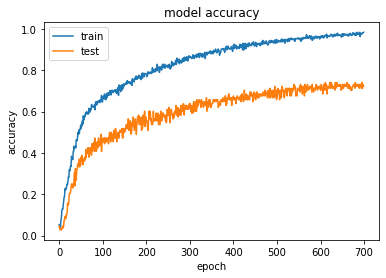

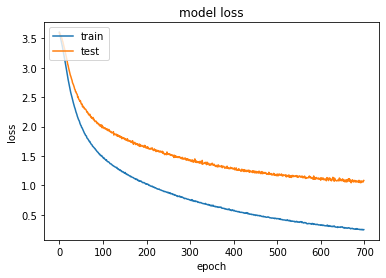

In [20]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()